In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [82]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P
from mppi.Utilities import Tools
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
from IPython.display import Image

In [3]:
omp = 1
mpi = 4 #16

In [4]:
code = C.QeCalculator(omp=omp,mpi=mpi,activate_BeeOND=False) 
#code = C.QeCalculator(omp=omp,mpi=mpi,scheduler='slurm',sbatch_options=['--partition=all12h'])
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler direct


{'omp': 1,
 'mpi': 4,
 'mpi_run': 'mpirun -np',
 'executable': 'pw.x',
 'scheduler': 'direct',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'sbatch_options': [],
 'activate_BeeOND': False,
 'verbose': True}

# DFT analysis of the Germanene (monolayer) 

This notebook contains the DFT analysis of the Germanene performed with QuantumESPRESSO. In particular

* GS is computed directly _at convergence_ using the input file from a previous convergence analysis. 
* We analyze the DFT band structure

## Geometric setup

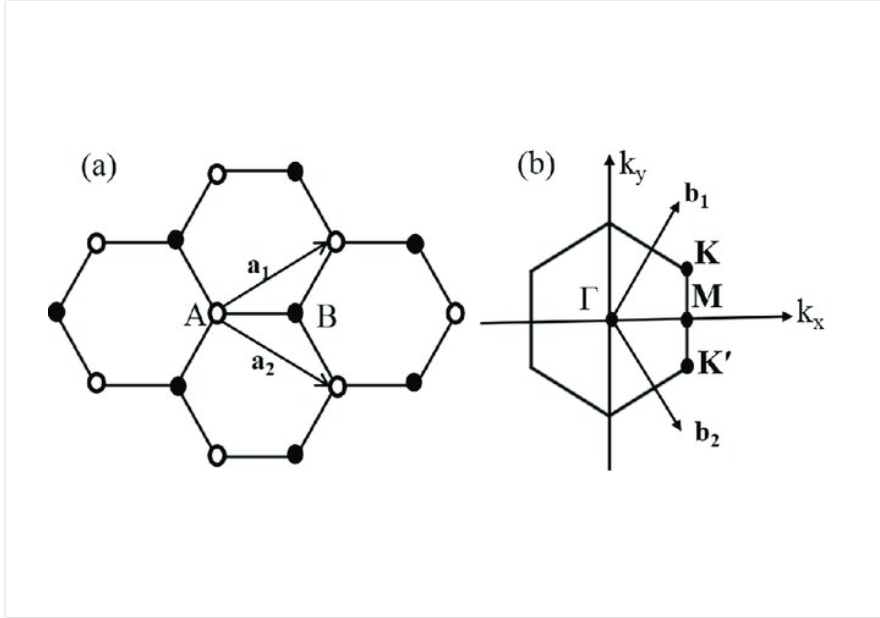

In [26]:
Image('Honeycomb_lattice.png',width=600)

The lattice is oriented with the zig-zag along the y axis. The basis vector are chosen as:

$$
a_1 = \frac{a}{2}(3,\sqrt{3},0) \, ,\quad a_2 = \frac{a}{2}(3,-\sqrt{3},0) \, ,\quad
a_3 = (0,0,c)
$$

Here $a$ represents the atoms nearest distance. The position of the atoms in the lattice is given by (note that the $A$ and $B$ defined in the
formula do _not_ match the labels in the figure):
$$
A = (0,0,\delta) \, \qquad B = \frac{a}{2}(1,\sqrt{3},-\delta)
$$
where $\delta$ is the buckling parameter. The lattice constant is related to the atoms distance by $a_{lat} = \sqrt{3}a$.

The position of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) are given by:

$$
M = (\frac{1}{\sqrt{3}},0) \, \quad
K = (\frac{1}{\sqrt{3}},\frac{1}{3}) 
$$

## GS Analysis

The $a$ and $\delta$ parameters are computed from the original input file, through the distance of the atomic positions.

The $a_{lat}$ and $c$ parametes are read from the celldm(1) and celldm(3) values of the original input.

In [74]:
alat = 7.643 # in a.u.
c = alat*8 # in a.u
pos1 = alat*np.array([0.0, 0.5773503, 0.083971326]) 
pos2 = alat*np.array([0.5, 0.2886751, -0.083971326]) 
a = np.linalg.norm(pos2[0:2]-pos1[0:2])
delta = pos1[2]
a,delta

(4.412688357362254, 0.641792844618)

and we obtain $a_{lat} = \sqrt{3}a$ as expected.

We set the lattice vectors and atomic positions in the basis defined above

In [75]:
a1 = np.array([a/2.*3.,a/2.*np.sqrt(3.),0.])
a2 = np.array([a/2.*3.,-a/2.*np.sqrt(3.),0.])
a3 = np.array([0.,0.,c])
A = np.array([0.,0.,delta])
B = np.array([a/2.,a/2.*np.sqrt(3.),-delta])

We build the input using the convergence parameters of the original input file.

In [76]:
pseudo = 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF'
pseudo_dir = '../pseudos'
run_dir = 'DFT_analysis'
prefix = 'GS_converged'
ecut_wf = 90 # energy cutoff on the wavefunction (Ry)
kpoints = [12.,12.,1.]

In [77]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6) # needed for the Yambo simulations
inp.set_prefix(prefix)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_energy_cutoff(ecut_wf)
inp.set_spinorbit()
inp.add_atom(atom='Ge',pseudo_name=pseudo,mass=72.64)
inp.set_atoms_number(2)
inp.set_atomic_positions([['Ge',A],['Ge',B]],type='bohr')
inp.set_lattice(ibrav=0,cell_vectors=[a1,a2,a3],cell_units='bohr')
inp.set_kpoints(points = kpoints)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'GS_converged'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ecutwfc': 90,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 0},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ge': [72.64, 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF']},
 'atomic_positions': {'type': 'bohr',
  'values': [['Ge', array([0.        , 0.        , 0.64179284])],
   ['Ge', array([ 2.20634418,  3.82150022, -0.64179284])]]},
 'kpoints': {'type': 'automatic',
  'values': ([12.0, 12.0, 1.0], [0.0, 0.0, 0.0])},
 'cell_parameters': {'type': 'bohr',
  'values': [array([6.61903254, 3.82150022, 0.        ]),
   array([ 6.61903254, -3.82150022,  0.        ]),
   array([ 0.   ,  0.   , 61.144])]}}

In [78]:
results = code.run(run_dir=run_dir,input=inp,name=prefix,skip=False)

delete log file: DFT_analysis/GS_converged.log
delete xml file: /home/marco/Data/RICERCA/DFT AND MANY BODY/2D ELECTRONIC AND OPTICAL PROPERTIES/GERMANENE/DFT_analysis/GS_converged.xml
delete folder: /home/marco/Data/RICERCA/DFT AND MANY BODY/2D ELECTRONIC AND OPTICAL PROPERTIES/GERMANENE/DFT_analysis/GS_converged.save
run command: mpirun -np 4 pw.x -inp GS_converged.in > GS_converged.log
computation GS_converged is running...
computation GS_converged ended


Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [88]:
bands_prefix = 'bands'

G = [0.,0.,0.]
M = [1./np.sqrt(3.),0.,0.]
K = [1./np.sqrt(3.),1./3.,0.]
high_sym = {'G':G,'K':K,'M':M} # useful to label the high-sym point on the path

In [89]:
klist = Tools.build_kpath(G,M,K,G,numstep=30)
klist

[[0.0, 0.0, 0.0, 30],
 [0.5773502691896258, 0.0, 0.0, 30],
 [0.5773502691896258, 0.3333333333333333, 0.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [90]:
inp.set_bands(32)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.false.',
  'ecutwfc': 90,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 0,
  'nbnd': 32},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-08},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ge': [72.64, 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF']},
 'atomic_positions': {'type': 'bohr',
  'values': [['Ge', array([0.        , 0.        , 0.64179284])],
   ['Ge', array([ 2.20634418,  3.82150022, -0.64179284])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 30],
   [0.5773502691896258, 0.0, 0.0, 30],
   [0.5773502691896258, 0.3333333333333333, 0.0, 30],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {'type': 'bohr',
  'values': [array([6.61903254, 3.82150022, 0.        ]),
   array([ 6.61903254, -3.82150022,  0.        ]),
   array([ 0.   ,  0.   , 61.144])]}

In [93]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir=os.path.join(run_dir,prefix)+'.save')

copy source_dir DFT_analysis/GS_converged.save in the /home/marco/Data/RICERCA/DFT AND MANY BODY/2D ELECTRONIC AND OPTICAL PROPERTIES/GERMANENE/DFT_analysis/bands.save
run command: mpirun -np 4 pw.x -inp bands.in > bands.log
computation bands is running...
computation bands ended


In [105]:
data = P.PwParser(results)

Parse file : /home/marco/Data/RICERCA/DFT AND MANY BODY/2D ELECTRONIC AND OPTICAL PROPERTIES/GERMANENE/DFT_analysis/bands.save/data-file-schema.xml


In [106]:
data.get_gap()

Direct gap system
Gap : 0.02207881414174251 eV


{'gap': 0.02207881414174251,
 'direct_gap': 0.02207881414174251,
 'position_cbm': 60,
 'positon_vbm': 60}

Once that the computation is over we can create an instance of PwBands

In [94]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [95]:
bands.get_high_sym_positions()

(['G', 'G', 'K', 'M'],
 [0.0, 1.5773502657018026, 0.9106835999999987, 0.57735027])

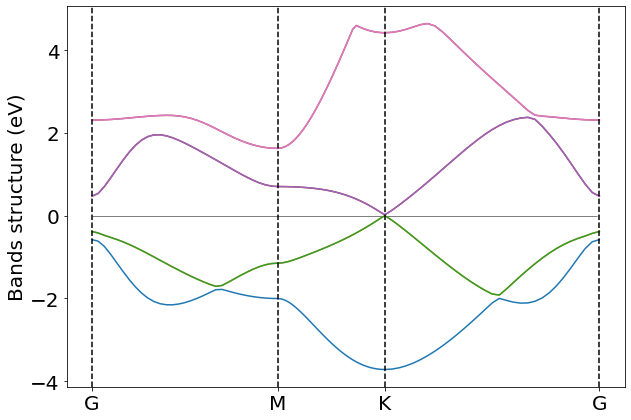

In [113]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 7))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(25,32)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

We plot the bands near the Dirac cone

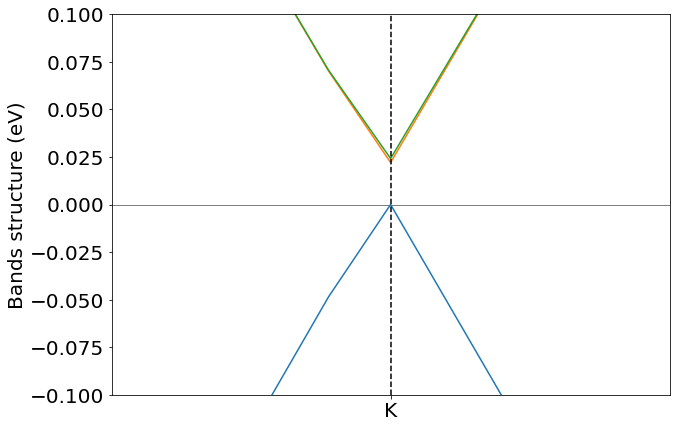

In [126]:
label_size = 20
K_pos = bands.get_high_sym_positions()[1][2]
dk = 0.05

fig, ax = plt.subplots(figsize=(10, 7))
bands.plot(plt,selection=[i for i in range(27,30)])
ax.set_xlim(K_pos-dk,K_pos+dk)
ax.set_ylim(-0.1,0.1)
ax.hlines(0.,0.,1.7,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

The gap of 22 meV is clearly visible.